# Uczenie głębokie cz. I

Ten notatnik ma na celu przedstawienie jednego ze sposobów tworzenia głębokich sieci neuronowych w Pythonie. W trakcie zadania najpierw stworzymy prostą sieć konwolucyjną, a następnie zbadamy jej proces uczenia się. Na tych zajęciach wykorzystamy biblioteki [Keras](https://keras.io/) i [Tensorflow](https://www.tensorflow.org/).

Po wykonaniu tego zadania powinieneś:
+ wiedzieć z jakich części składają się sieci konwolucyjne,
+ potrafić uruchomić sieć neuronową na własnych danych,
+ wiedzieć jak wczytać i wykorzystać gotowy model,
+ zwizualizować i śledzić na żywo proces uczenia się sieci.

## Prosta sieć konwolucyjna

Najpierw załadujemy odpowiednie biblioteki i wczytamy mały zbiór obrazów do uczenia się rozpoznawania liczb. 

**Zad. 1:Przejrzyj komentarze przy operacjach `import`, aby zapoznać się z nazewnictwem w bibliotece Keras.**

In [ ]:
import numpy as np
np.random.seed(23)
from matplotlib import pyplot as plt

# Typ sieci
from keras.models import Sequential # tworzymy typową sieć jednokierunkową (bez rekurencji)

# Typy warstw
from keras.layers import Dense # warstwa z w pełni połączona (wszystkie neurony z poprzedniej warstwy do każdego w kolejnej)
from keras.layers import Dropout # mechanizm losowego wyłączania neuronów (pozwala uniknąć przeuczenia)
from keras.layers import Activation # aktywacja, czyli funkcja przyjmująca jedną liczbę (np. sigmoid, softmax) 
from keras.layers import Flatten # spłaszczenie wejścia (np. zamiana tensora o wymiarach 64x32x32 na wektor o długości 65536)
from keras.layers import Conv2D # warstwa konwolucyjna, tworzy filtry o zadanym rozmiarze w zadanych odstępach
from keras.layers import MaxPooling2D # warstwa zmniejszająca obraz poprzez operacje max na zadanym rozmiarze pikseli

# Optymalizator i funkcja straty
from keras import optimizers
from keras import losses

# "Przydasie"
from keras import utils as k_utils
from keras.models import load_model
from keras.callbacks import TensorBoard
import time

Czas na zbiór danych. Skorzystamy ze standardowego zbioru treningowego do omawiania sieci konwolucyjnych, czyli [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór składa się z małych obrazków, więc będziemy w stanie nauczyć sieć na zwykłym komputerze, a sieci konwolucyjne są tu jak najbardziej potrzebne do uzyskania sensownych wyników.

Biblioteka Keras ma funkcję pobierającą ten zbiór z sieci, z czego skrzętnie skorzystamy.

In [46]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

**Zad. 2: Sprawdź jakie wymiary mają załadowane obrazki. Przypisz te wartości do zmiennych img_rows, img_cols. Sprawdź również liczbę klas i przypisz tę wartość to zmiennej `num_classes`.**

In [47]:
# sprawdź wymiary zbioru danych

img_rows = X_train[0].shape[0]
img_cols = X_train[0].shape[1]
num_classes = len(set(y_train))
print("img_rows: ", img_rows)
print("img_cols: ", img_cols)
print("num_classes: ", num_classes)

img_rows:  28
img_cols:  28
num_classes:  10


**Zad. 3: Wyświetl pierwszy rysunek ze zbior.**

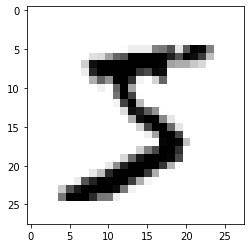

In [48]:
plt.imshow(X_train[0], cmap='binary')

## Wstępne przetwarzanie danych

Ponieważ obrazy mogą mieć różną liczbę kolorów (kanałów), musimy powiedzieć Kerasowi jaki format danych będzie przetwarzać. Obrazy mogą mieć jeden kanał (skala szarości), trzy kanały (RGB), a czasami więcej niż trzy kanały (np. zdjęcia satelitarne). Dane w zbiorze MNIST są zakodowane w skali szarości, a zatem mają jeden kanał.

**Zad. 4: Zmień wymiarowość danych wejściowych zgodnie z poniższym wzorem.**

In [49]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

Oprócz określenia wymiaru danych wejściowych musimy upewnić się, że są one typu `float32`. Ponadto warto ustandaryzować dane wejściowe lub sprowadzić je do zakresu [0-1]. My uczynimy to drugie.

In [50]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Ostatnia rzecz, którą musimy zrobić to zakodować klasy (`y`) w sposób binarny. Czyli zamiast klas `1, 2, ... 10` itd., chcemy uzyskać kodowanie w postaci `[1 0 0 0 0 0 0 0 0 0], [0 1 0 0 0 0 0 0 0 0] ... [0 0 0 0 0 0 0 0 0 1]`. W Kerasie posłuży nam do tego funkcja `to_categorical()`.

In [51]:
y_train = k_utils.to_categorical(y_train, num_classes)
y_test = k_utils.to_categorical(y_test, num_classes)

## Tworzenie sieci

W Kerasie **architekturę sieci** definiuje się poprzez podanie typu sieci i kolejnych warstw. Dla każdej warstwy określa się typ neuronów, ich liczbę i (jeśli to konieczne) ich parametry.

Poniżej zdefiujemy prostą sieć konwolucyjną. Będzie się ona składała tylko z dwóch warstw konwolucyjnych, bo zdjęcia na których operujemy są bardzo małe. Większe zdjęcia wymagałyby więcej warstw. Uwaga! W uporszczeniu: im większa sieć tym większe wymagania pamięciowe i czasowe!

Nasza architektura to (porównaj z poniższym kodem):
- **warstwa konwolucyjna** tworząca **32 filtry** o rozmiarze **3x3**. Każdy filtr stanowi wejście dla funkcji atywacyjnej typu **ReLU**. Zauważ, że w pierwszej warstwie sieci musimy podać wymiary (warstwę wejściową). W kolejnych warstwach nie jest to konieczne, bo warstwy wiedzą jak mają się łączyć.
- **warstwa konwolucyjna** tworząca **64 filtry** o rozmiarze **3x3** z **ReLU**. 
- **warstwa pooling** zmiejszająca obraz o połowę
- **warstwa dropout** losowo wyłączają 1/4 neuronów przy każdym przejściu
- **warstwę spłaszczającą** wielowymiarowe konwolucje w wektor
- **w pełni połączona warstwa** 128 neuronów
- **kolejny dropout**
- **warstwa wyjściowa** posiadającą tyle neuronów ile mamy klas

**Zad. 5: W ostatniej warstwie nie podałem funkcji aktywacji. Wróć do slajdów i sprawdź jaka funkcja aktywacji nada się do klasyfikacji.**

In [52]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

Po stworzeniu sieci w Kerasie trzeba ją skompilować. W tym kroku Keras dostosowuje kod pod wykonanie na wybranym backendzie. W naszym przypadku będzie to Tensorflow, ale równie dobrze mogłyby to być platformy Theano lub CNTK.

Podczas kompilacji podajemy **funkcję straty**, **optymalizator**. Ponadto można podać szereg miar do śledzenia (typowo przy klasyfikacji accuracy).

**Zad. 6: Wróć do slajdów i sprawdź jaka funkcja straty nada się do klasyfikacji wieloklasowej. Jako optymalizator wybierz Adadelta, dzięki temu nie będziesz musiał podawać learning rate. Protip: użyj Tab.**

In [53]:
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

## Uczenie sieci

Mamy sieć. Teraz nic tylko odpalić uczenie. Robiąc to musimy podać **batch_size** (czyli ile przykładów przepuszczamy przez sieć między aktualizacją wag) i liczbę **epok** (czyli ile razy chcemy przepuścić przez sieć cały zbiór danych). Zbiór walidacyjny będzie nam mówił na ile dobrze sieć działa na danych, których wcześniej nie widzieliśmy.

In [28]:
model.fit(X_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test))

# Jak kod ruszy, oszacuj ile zajmie uczenie sieci (ETA jednej epoki x liczba epok).
# Jeśli wychodzi Ci więcej niż 3 minuty zatrzymaj uczenie i czytaj dalej...

Epoch 1/12
469/469 [==============================] - 72s 153ms/step - loss: 2.2719 - accuracy: 0.1551 - val_loss: 2.2263 - val_accuracy: 0.3458
Epoch 2/12
469/469 [==============================] - 74s 157ms/step - loss: 2.1984 - accuracy: 0.2817 - val_loss: 2.1345 - val_accuracy: 0.5407
Epoch 3/12
469/469 [==============================] - 82s 175ms/step - loss: 2.1046 - accuracy: 0.3831 - val_loss: 2.0117 - val_accuracy: 0.6548
Epoch 4/12
469/469 [==============================] - 82s 176ms/step - loss: 1.9740 - accuracy: 0.4708 - val_loss: 1.8454 - val_accuracy: 0.7186
Epoch 5/12
469/469 [==============================] - 75s 160ms/step - loss: 1.8126 - accuracy: 0.5337 - val_loss: 1.6402 - val_accuracy: 0.7611
Epoch 6/12
469/469 [==============================] - 89s 190ms/step - loss: 1.6281 - accuracy: 0.5815 - val_loss: 1.4181 - val_accuracy: 0.7862
Epoch 7/12
469/469 [==============================] - 75s 160ms/step - loss: 1.4459 - accuracy: 0.6179 - val_loss: 1.2088 - val_ac

Spójrzmy na ETA. Aha, ale to tylko 1 epoka z 12... Hmmm.... Trochę będzie trzeba poczekać. Zatrzymaj powyższy blok kodu. Zaraz coś z tym zrobimy...

In [29]:
model.save("cpu_cnn_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cpu_cnn_model/assets


In [32]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True) 

Num GPUs Available:  0


## GPU

Uczenie sieci to bardzo czasochłonny proces. Na szczeście, ze względu na swoją modularność, sieci bardzo łatwo się zrównolegla. Stąd gotowość większości bibliotek do współpracy z kartami graficznymi (jednakże obecnie są to praktycznie tylko karty NVidii).

Ponieważ prawdopodobnie nie masz komputera z super-ekstra kartą graficzną do obliczeń równoległych, skorzystamy z karty graficznej w chmurze. AWS, Google Cloud, Microsoft Azure chętnie udostępnią swoje moce obliczeniowe za drobną opłatą. Maszyny wirtualne z GPU są stosunkowo drogie w porównaniu do innych maszyn, ale przy naliczaniu godzinowym (a niekiedy sekundowym) jest to bardzo interesująca opcja. Jeśli masz dostęp do jednej z tych platform, albo lepiej dostęp i niewykorzystany kredyt, warto z tego skorzystać.

Aby zaoszczędzić sobie czasu nie będziemy stawiać pełnoprawnych wirtualek na żadnej z wymienionych platform. Zamiast tego szybko założymy konto na stronie Crestle, gdzie będziemy mieli godzinę darmowych obliczeń (z naliczaniem sekundowym):
1. Wejdź na https://www.crestle.ai/ i załóż konto.
2. Po zalogowaniu upewnij się, że włączony jest przełącznik **Enable GPU**
3. Kliknij **Start Jupyter**
4. Po zalogowaniu po prawej stronie nad listą plików kliknij na **Upload** (a potem znów upload)
5. Wgraj notebook
6. Odpal kod

**Zad 7. Wykonaj powyższe kroki i naucz sieć z tego notebooka na GPU. Uwaga Crestle będzie się trochę rozgrzewał zanim ruszy pełną parą. Po zakończeniu obliczeń zapisz model do pliku za pomocą poniższego kodu. Następnie ściągnij utworzony plik modelu z Crestle i zamknij zdalnego Jupytera.**

In [ ]:
# model.save("gpu_cnn_model")

## Wczytywanie modelu i predykcje

Uczenie się trwa długo, ale jak już mamy nauczoną sieć to wcale nie zajmuje ona aż tyle miejsca na dysku i działa bardzo szybko. Sprawdźmy czy tak rzeczywiście jest.

**Zad. 8: Wczytaj model nauczony na GPU na swoim lokalnym komputerze i dokonaj predykcji zgodnie z poniższym szablonem.**

In [34]:
%%time
gpu_model = load_model("cpu_cnn_model")

CPU times: user 838 ms, sys: 41.9 ms, total: 880 ms
Wall time: 1.4 s


In [35]:
%%time
score = gpu_model.evaluate(X_test, y_test, verbose=0)
print('{0} przykładów'.format(X_test.shape[0]))
print('loss={0:.4f}, accuracy={1:.4f}'.format(score[0], score[1]))

10000 przykładów
loss=0.6497, accuracy=0.8527
CPU times: user 11.8 s, sys: 853 ms, total: 12.7 s
Wall time: 2.48 s


U mnie na laptopie wyszło ok. 9 sekund. Dzieląc to przez liczbę przykładów wychodzi 10000/9 = 1111 obrazów na sekundę, czyli nie tak źle. Zwłaszcza, że mój komputer ma ponad 5 lat.

## Tensorboard

Tensorflow udostępnia świetne narzędzie do wizualizacji procesu uczenia sieci o nazwie **Tensorboard**. Aby je uruchomić odpal Anaconda Prompt i wpisz następujące polecenie:

```
tensorboard --logdir="pelna_sciezka_do_tego_notebooka/logs"
```

**Zad. 9: Odpal Tensorboarda a następnie uruchom (lokalnie) poniższy kod. W trakcie gdy sieć się uczy wejdź na stronę Tensorboard i sledź zmiany.**

In [54]:
epochs = 12
batch_size = 128
dataset_size = 1000

# Protip: w nazwie modelu zawrzyj wartości parametrów, wtedy będzie można łatwo porównywać różne architektury/parametry
model_name = "cpu_cnn_model" + \
    "_e=" + str(epochs) + "_b=" + str(batch_size) + \
    "_n=" + str(dataset_size) + "_t=" + time.strftime("%Y%m%d_%H%M%S", time.localtime())

tb_callback = TensorBoard(log_dir="./logs/" + model_name, batch_size=128, histogram_freq=-1,
                          write_graph=True, write_images=False)

model.fit(X_train[:dataset_size,:,:,:], y_train[:dataset_size,:],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test[:dataset_size,:,:,:], y_test[:dataset_size,:]),
          callbacks=[tb_callback])

Epoch 1/12
8/8 [==============================] - 1s 184ms/step - loss: 2.3110 - accuracy: 0.0970 - val_loss: 2.3013 - val_accuracy: 0.1000
Epoch 2/12
8/8 [==============================] - 1s 131ms/step - loss: 2.3033 - accuracy: 0.1170 - val_loss: 2.2998 - val_accuracy: 0.1010
Epoch 3/12
8/8 [==============================] - 1s 125ms/step - loss: 2.3055 - accuracy: 0.1030 - val_loss: 2.2982 - val_accuracy: 0.1050
Epoch 4/12
8/8 [==============================] - 1s 128ms/step - loss: 2.3090 - accuracy: 0.1100 - val_loss: 2.2966 - val_accuracy: 0.1060
Epoch 5/12
8/8 [==============================] - 1s 125ms/step - loss: 2.2981 - accuracy: 0.1350 - val_loss: 2.2951 - val_accuracy: 0.1100
Epoch 6/12
8/8 [==============================] - 1s 128ms/step - loss: 2.3049 - accuracy: 0.1100 - val_loss: 2.2936 - val_accuracy: 0.1130
Epoch 7/12
8/8 [==============================] - 1s 129ms/step - loss: 2.2998 - accuracy: 0.1120 - val_loss: 2.2921 - val_accuracy: 0.1190
Epoch 8/12
8/8 [====

**Zad. 10: Zmień batch size na 64, zbuduj i skompiluj ponownie sieć (kod z zad. 5 i 6) i odpal uczenie jeszcze raz. Porównaj krzywe uczenia w Tensorboard.**

In [55]:
epochs = 12
batch_size = 64
dataset_size="ALL"
# Protip: w nazwie modelu zawrzyj wartości parametrów, wtedy będzie można łatwo porównywać różne architektury/parametry
model_name = "cpu_cnn_model" + \
    "_e=" + str(epochs) + "_b=" + str(batch_size) + \
    "_n=" + str(dataset_size) + "_t=" + time.strftime("%Y%m%d_%H%M%S", time.localtime())

tb_callback = TensorBoard(log_dir="./logs/" + model_name, batch_size=batch_size, histogram_freq=-1,
                          write_graph=True, write_images=False)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tb_callback])

Epoch 1/12
938/938 [==============================] - 65s 69ms/step - loss: 2.2095 - accuracy: 0.2497 - val_loss: 2.0950 - val_accuracy: 0.5897
Epoch 2/12
938/938 [==============================] - 69s 74ms/step - loss: 2.0175 - accuracy: 0.4476 - val_loss: 1.8412 - val_accuracy: 0.6969
Epoch 3/12
938/938 [==============================] - 62s 66ms/step - loss: 1.7638 - accuracy: 0.5464 - val_loss: 1.5213 - val_accuracy: 0.7665
Epoch 4/12
938/938 [==============================] - 65s 69ms/step - loss: 1.4921 - accuracy: 0.6096 - val_loss: 1.2140 - val_accuracy: 0.7968
Epoch 5/12
938/938 [==============================] - 73s 78ms/step - loss: 1.2626 - accuracy: 0.6547 - val_loss: 0.9775 - val_accuracy: 0.8170
Epoch 6/12
938/938 [==============================] - 69s 73ms/step - loss: 1.0872 - accuracy: 0.6911 - val_loss: 0.8119 - val_accuracy: 0.8330
Epoch 7/12
938/938 [==============================] - 84s 90ms/step - loss: 0.9694 - accuracy: 0.7160 - val_loss: 0.7009 - val_accuracy:

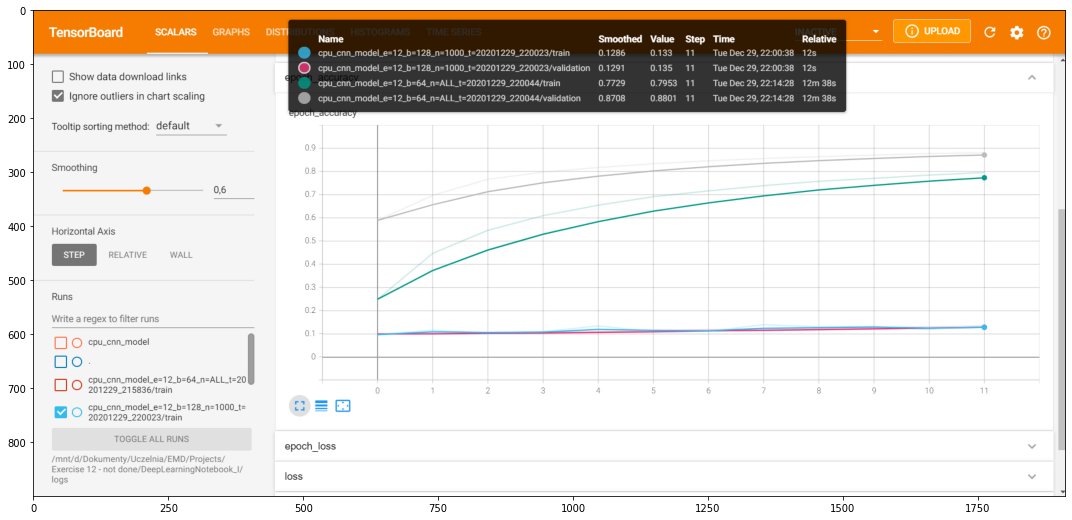

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
img = mpimg.imread("tensorboard.png")
plt.imshow(img)

Poznałeś podstawy tego co jest potrzebne aby nauczyć własną głęboką sieć neuronową od zera. O tym jakie inne architektury zaproponowano do różnych zadań i jak przyspieszyć proces uczenia sieci dla wielu standardowych problemów dowiesz się na następnych zajęciach.